In [142]:
# !pip install pandas --quiet
# !pip install openpyxl --quiet
# !pip install sklearn --quiet
# !pip install matplotlib --quiet
# !pip install seaborn --quiet
# !pip install xgboost --quiet
# !pip install statsmodels -- quiet
# !pip install simplefilter


In [143]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import classification_report,confusion_matrix
import statsmodels.api as sm
import statistics as st
from scipy.stats import f_oneway

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


In [144]:
data = pd.read_excel('health_dataset.xlsx')

## 1. Preliminary Analysis

In [145]:
print(data.shape)
print(data.columns)

(303, 14)
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')


Missing Values

In [146]:
data.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Duplicates

In [147]:
print('Before dropping duplicates')
print(f'Number of duplicates: {data.shape[0] - data.drop_duplicates().shape[0]}')
data.drop_duplicates(inplace=True)
print('')
print('After dropping duplicates')
print(f'Number of duplicates: {data.shape[0] - data.drop_duplicates().shape[0]}')

Before dropping duplicates
Number of duplicates: 1

After dropping duplicates
Number of duplicates: 0


Split the dataset into train and test

In [148]:
train,test,trainLab,testLab = train_test_split(data[[col for col in data.columns if col != 'target']],data['target'],test_size=0.2,random_state=314)

## Dictionary sorting dataset into numerical and categorical

In [149]:
train[[col for col in train.columns if 'scaled' not in col]]
var_type = {'num':['age','trestbps','chol','thalach']}
var_type['cat'] = [col for col in train.columns if col not in var_type['num']]

## 2. Prepare a Report About the Data

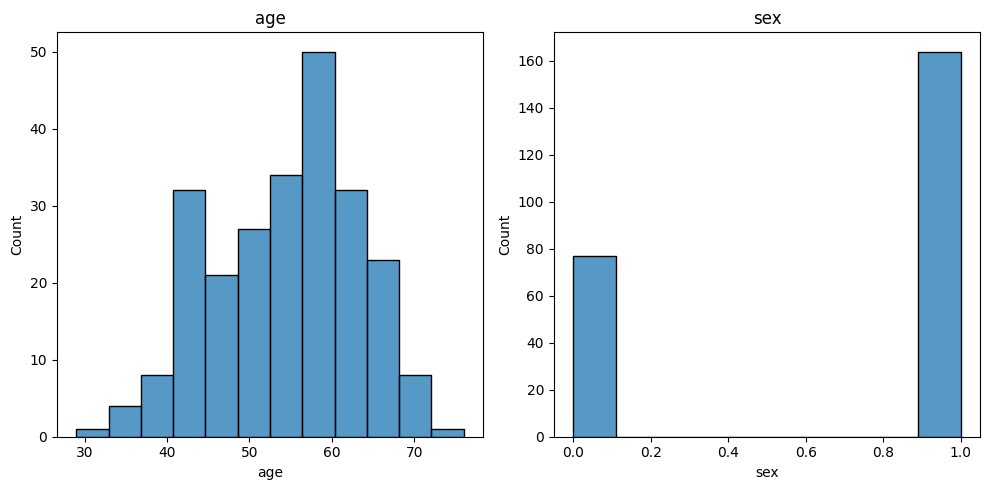

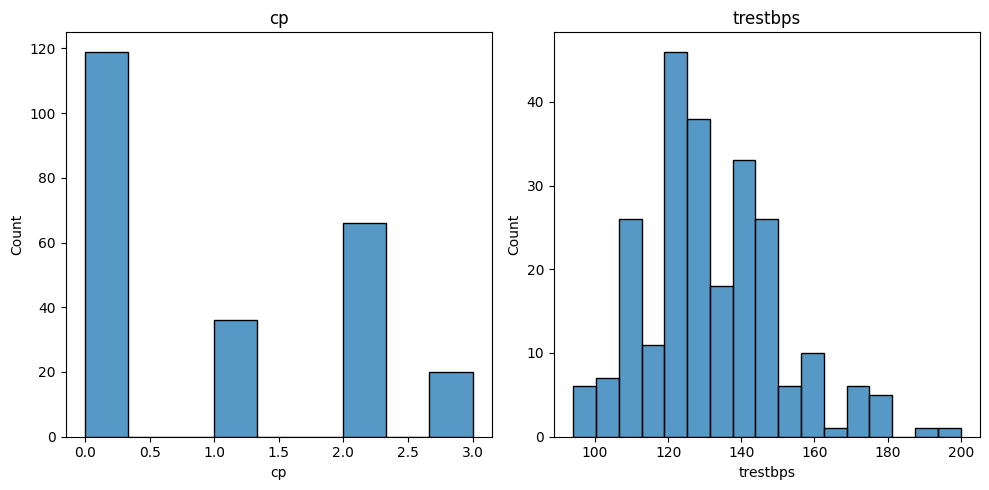

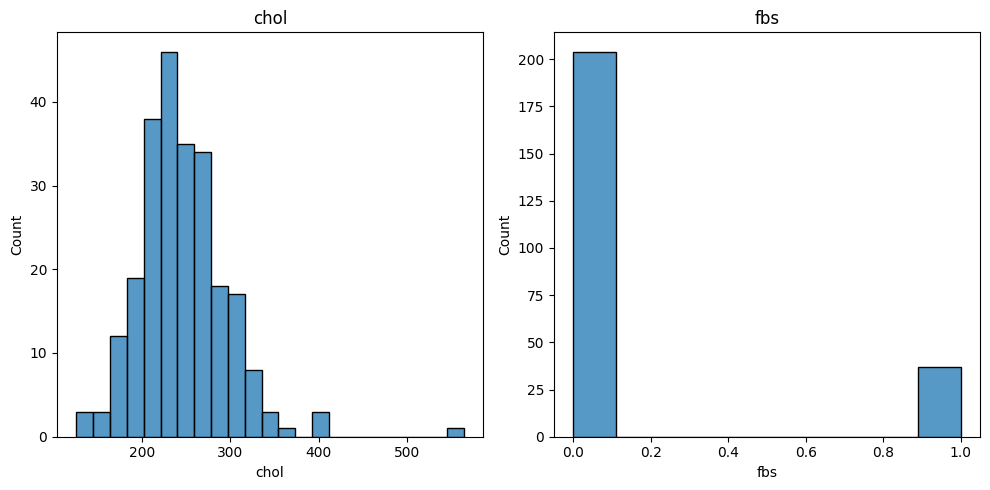

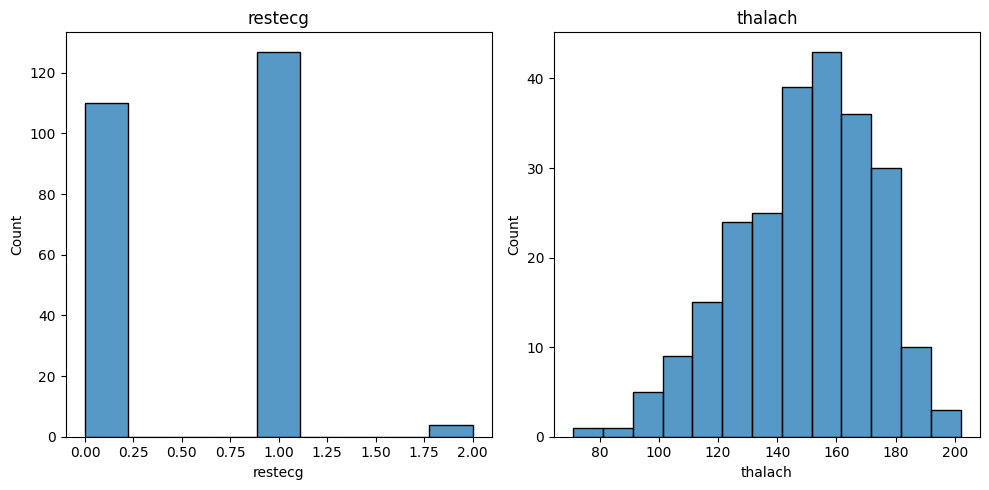

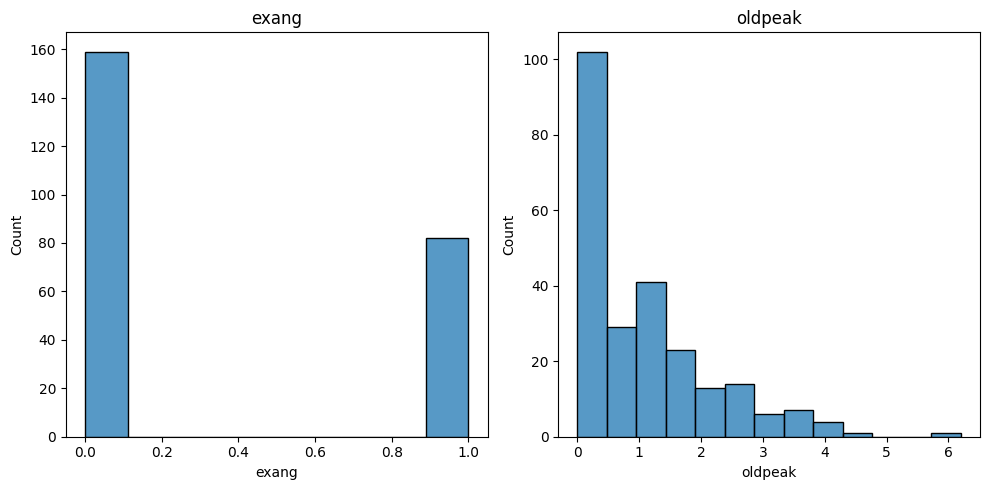

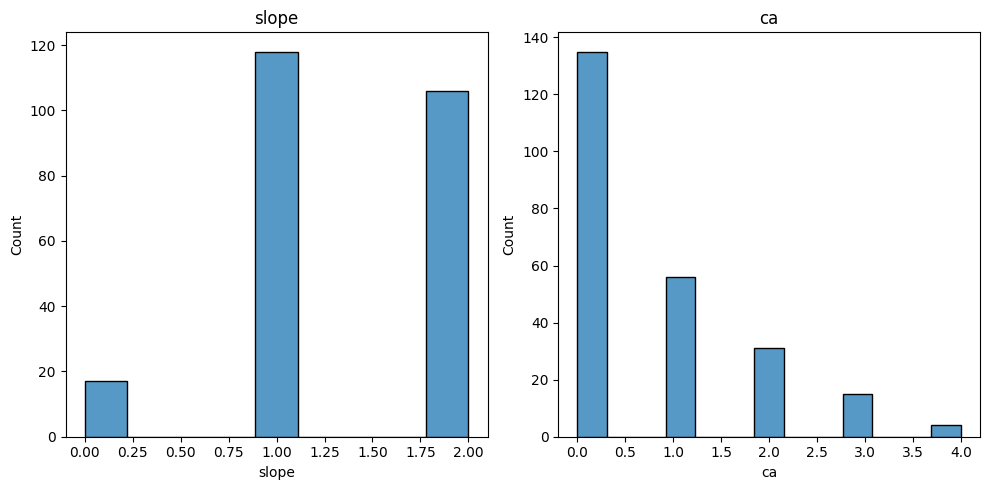

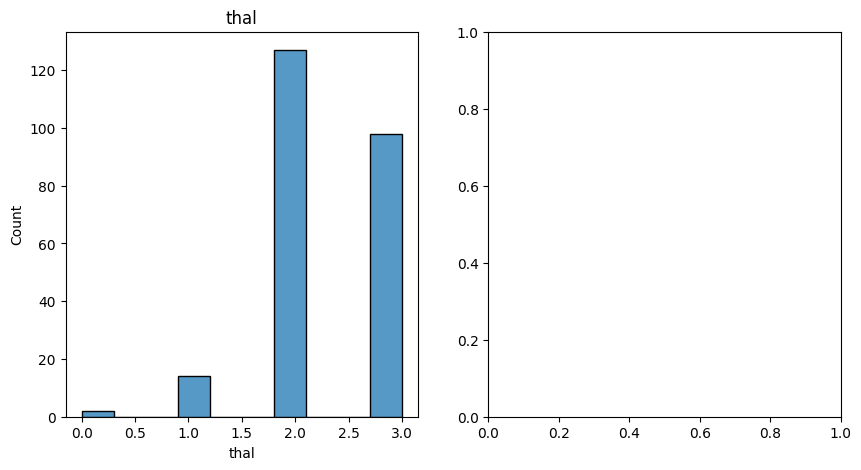

In [150]:
## Show the distribution of each variable

cols = train.columns
for i in range(0,len(cols),2):
    plt.figure(figsize=(10,5))
    plt.subplot(121)
    plt.title(cols[i])
    sns.histplot(train[cols[i]])
    try:
        plt.subplot(122)
        plt.title(cols[i+1])
        sns.histplot(train[cols[i+1]])
        plt.tight_layout()
        plt.show()
    except:
        pass
    plt.show()


## Measures of Centeral Tendency

In [151]:
def st_err(col):
    return train[col].std()/np.sqrt(train[col].shape[0] - 1)


In [152]:
for col in var_type['num']:
    print(col)
    print(train[col].mean())
    print(st_err(col))
    print('')

for col in var_type['cat']:
    print(col)
    print(st.mode(train[col]))
    print(st.mean(train[col]))

age
54.448132780082986
0.5754467114373067

trestbps
132.10373443983403
1.1927181159642783

chol
246.31950207468878
3.252478751158942

thalach
148.87966804979254
1.4881447620686272

sex
1
0.6804979253112033
cp
0
0.946058091286307
fbs
0
0.15352697095435686
restecg
1
0.5601659751037344
exang
0
0.34024896265560167
oldpeak
0.0
1.0315352697095437
slope
1
1.3692946058091287
ca
0
0.7427385892116183
thal
2
2.33195020746888


## Study CVD Across Age Category

In [153]:
train_dummy = train.copy()
train_dummy['label'] = trainLab
train_dummy = train_dummy[[col for col in train_dummy.columns if 'scaled' not in col]]

CVD_pos = train_dummy[train_dummy['label'] == 1]
CVD_neg = train_dummy[train_dummy['label'] == 0]

l_pos = CVD_pos.shape[0]
l_neg = CVD_neg.shape[0]

In [154]:
help(sns.distplot)

Help on function distplot in module seaborn.distributions:

distplot(a=None, bins=None, hist=True, kde=True, rug=False, fit=None, hist_kws=None, kde_kws=None, rug_kws=None, fit_kws=None, color=None, vertical=False, norm_hist=False, axlabel=None, label=None, ax=None, x=None)
    DEPRECATED
    
    This function has been deprecated and will be removed in seaborn v0.14.0.
    It has been replaced by :func:`histplot` and :func:`displot`, two functions
    with a modern API and many more capabilities.
    
    For a guide to updating, please see this notebook:
    
    https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



# Ratio of CVD positive to CVD negative

In [155]:
l_pos/l_neg

1.1517857142857142

C:\Users\admin\AppData\Local\Temp\ipykernel_4152\91496893.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_pos['age'],color='blue',kde=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_4152\91496893.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_neg['age'],color='orange',kde=True

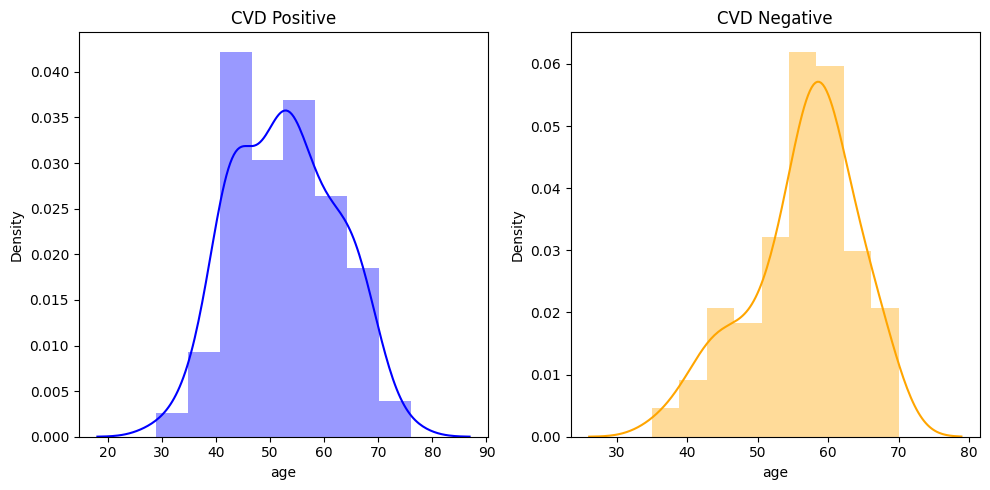

52.72093023255814
56.4375
p-value: 0.0011393822143607707


In [156]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CVD Positive')
sns.distplot(CVD_pos['age'],color='blue',kde=True)
plt.subplot(122)
plt.title('CVD Negative')
sns.distplot(CVD_neg['age'],color='orange',kde=True)
plt.tight_layout()
plt.show()

print(CVD_pos['age'].mean())
print(CVD_neg['age'].mean())
print(f'p-value: {f_oneway(CVD_pos["age"],CVD_neg["age"])[1]}')

## Study CVD across Sex

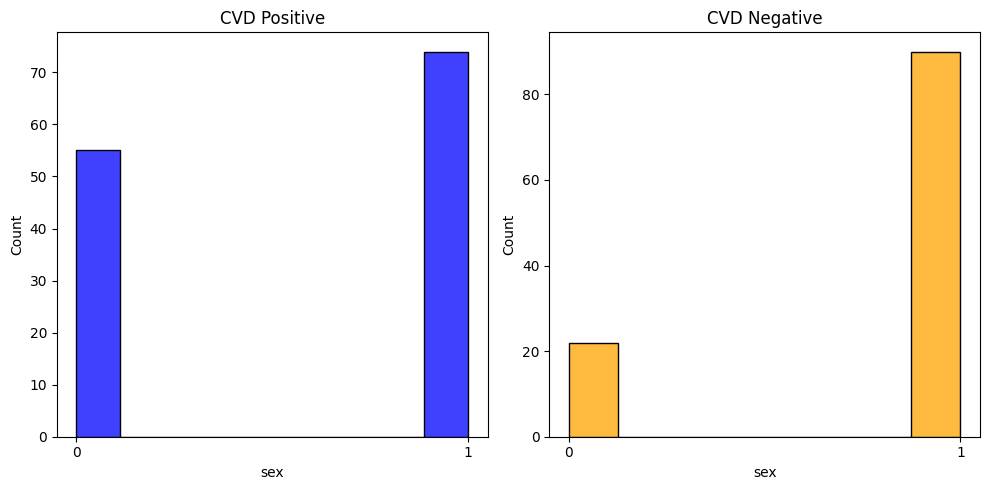

p-value: 0.00011451700090548587


In [157]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CVD Positive')
sns.histplot(CVD_pos['sex'],color='blue')
plt.xticks([0,1])
plt.subplot(122)
plt.title('CVD Negative')
sns.histplot(CVD_neg['sex'],color='orange')
plt.xticks([0,1])
plt.tight_layout()
plt.show()

print(f'p-value: {f_oneway(CVD_pos["sex"],CVD_neg["sex"])[1]}')

## Explore how anomolies in resting blood pressure are related to CV

C:\Users\admin\AppData\Local\Temp\ipykernel_4152\3095038990.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_pos['trestbps'],color='blue')
C:\Users\admin\AppData\Local\Temp\ipykernel_4152\3095038990.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_neg['trestbps'],color='orange')


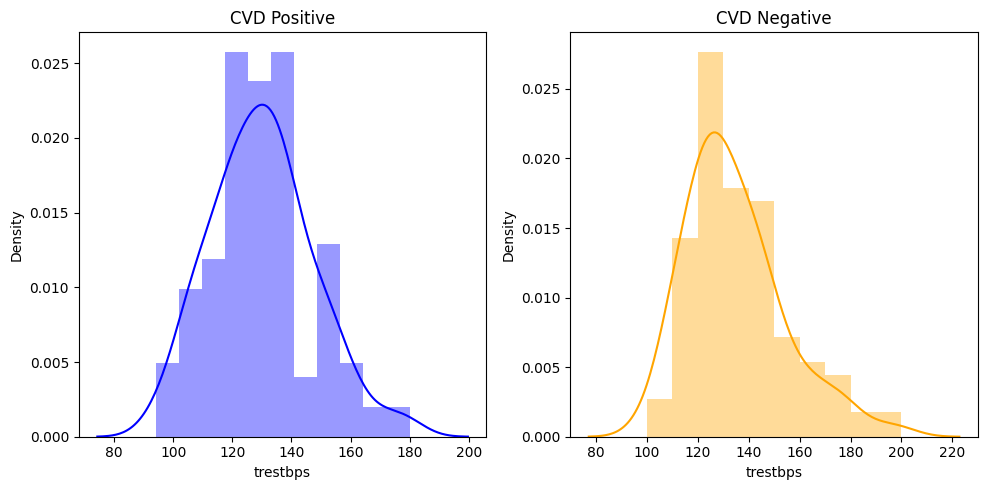

130.06201550387595
134.45535714285714
p-value: 0.06551289275492206


In [158]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CVD Positive')
sns.distplot(CVD_pos['trestbps'],color='blue')
plt.subplot(122)
plt.title('CVD Negative')
sns.distplot(CVD_neg['trestbps'],color='orange')
plt.tight_layout()
plt.show()
print(CVD_pos['trestbps'].mean())
print(CVD_neg['trestbps'].mean())
print(f'p-value: {f_oneway(CVD_pos["trestbps"],CVD_neg["trestbps"])[1]}')

# Check Relationship between cholesterol and CVD

C:\Users\admin\AppData\Local\Temp\ipykernel_4152\2477211145.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_pos[CVD_pos['chol'] < 500]['chol'],color='blue')
C:\Users\admin\AppData\Local\Temp\ipykernel_4152\2477211145.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_neg['chol'],col

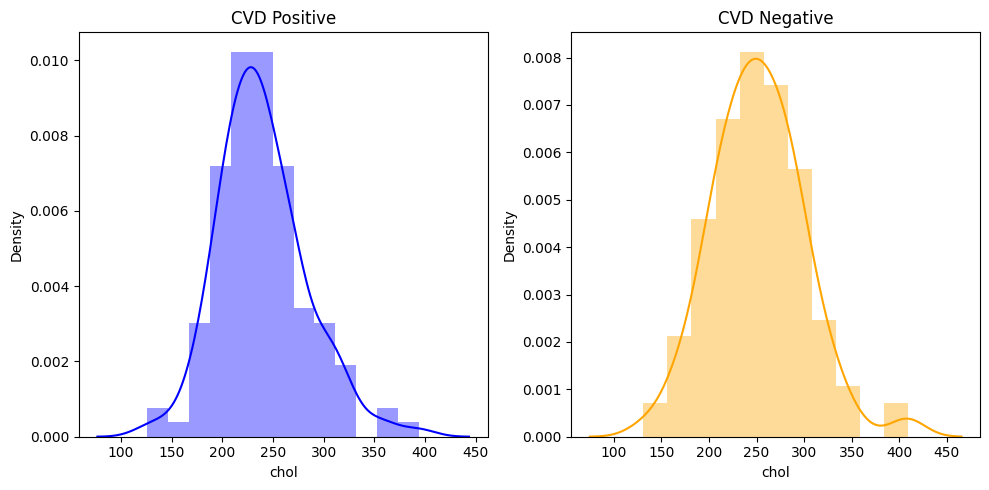

130.06201550387595
134.45535714285714
p-value: 0.11679582136653004


In [159]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CVD Positive')
sns.distplot(CVD_pos[CVD_pos['chol'] < 500]['chol'],color='blue')
plt.subplot(122)
plt.title('CVD Negative')
sns.distplot(CVD_neg['chol'],color='orange')
plt.tight_layout()
plt.show()
print(CVD_pos['trestbps'].mean())
print(CVD_neg['trestbps'].mean())
print(f'p-value: {f_oneway(CVD_pos["chol"],CVD_neg["chol"])[1]}')



# Effect of exercise induced effects on ST-Wave on CVD

C:\Users\admin\AppData\Local\Temp\ipykernel_4152\1506909088.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_pos['oldpeak'],color='blue')
C:\Users\admin\AppData\Local\Temp\ipykernel_4152\1506909088.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_neg['oldpeak'],color='orange')


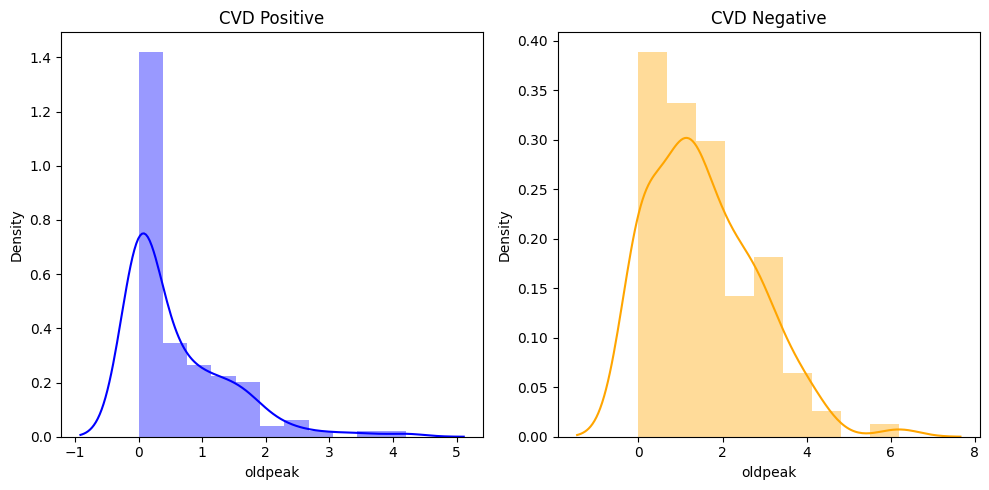

p-value: 1.610374824257576e-11


In [160]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CVD Positive')
sns.distplot(CVD_pos['oldpeak'],color='blue')
plt.subplot(122)
plt.title('CVD Negative')
sns.distplot(CVD_neg['oldpeak'],color='orange')
plt.tight_layout()
plt.show()
print(f'p-value: {f_oneway(CVD_pos["oldpeak"],CVD_neg["oldpeak"])[1]}')

C:\Users\admin\AppData\Local\Temp\ipykernel_4152\74673597.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_pos['slope'],color='blue')
C:\Users\admin\AppData\Local\Temp\ipykernel_4152\74673597.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_neg['slope'],color='orange')


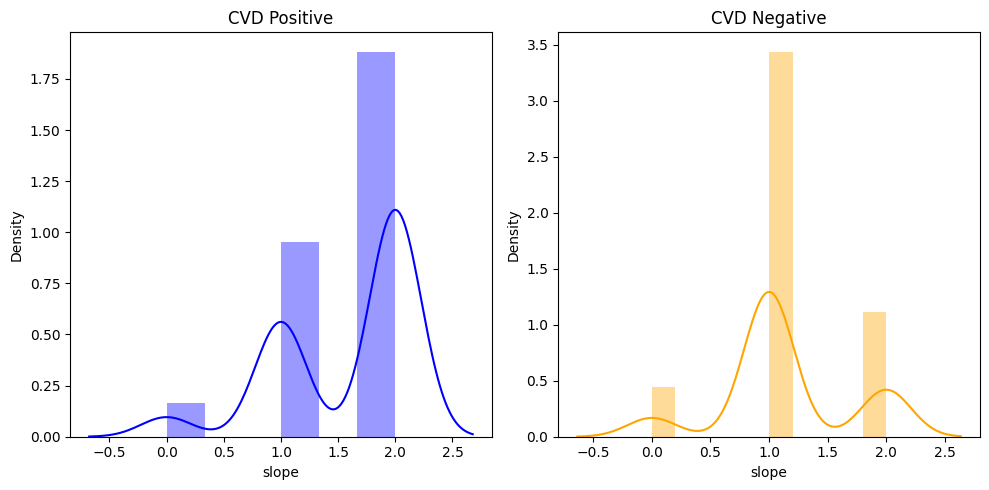

p-value: 1.0047065142986277e-08


In [161]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CVD Positive')
sns.distplot(CVD_pos['slope'],color='blue')
plt.subplot(122)
plt.title('CVD Negative')
sns.distplot(CVD_neg['slope'],color='orange')
plt.tight_layout()
plt.show()
print(f'p-value: {f_oneway(CVD_pos["slope"],CVD_neg["slope"])[1]}')

# Check if thalassemia is a major cause of CVD

C:\Users\admin\AppData\Local\Temp\ipykernel_4152\1389327252.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_pos['thal'],color='blue')
C:\Users\admin\AppData\Local\Temp\ipykernel_4152\1389327252.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(CVD_neg['thal'],color='orange')


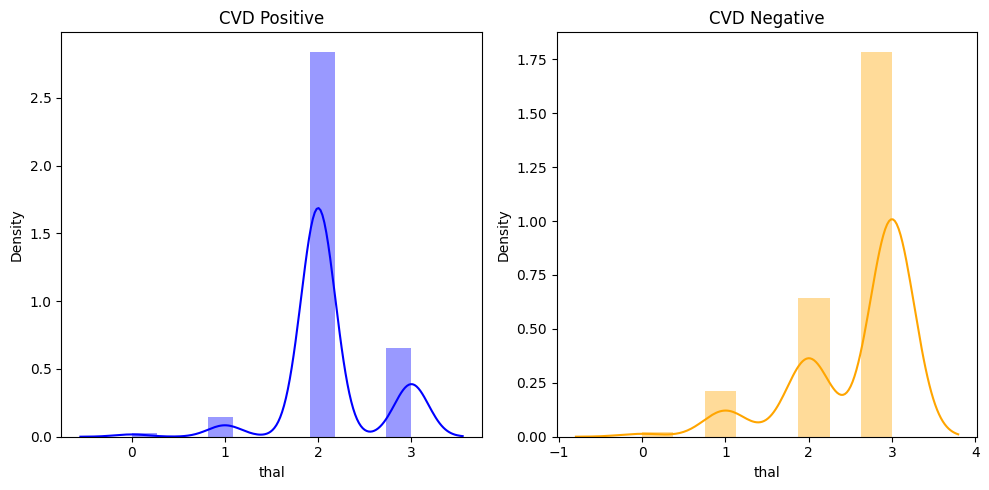

p-value: 1.0311500889007482e-08


In [162]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title('CVD Positive')
sns.distplot(CVD_pos['thal'],color='blue')
plt.subplot(122)
plt.title('CVD Negative')
sns.distplot(CVD_neg['thal'],color='orange')
plt.tight_layout()
plt.show()
print(f'p-value: {f_oneway(CVD_pos["thal"],CVD_neg["thal"])[1]}')

# List other factors involved in CVD

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,label
label,-0.208363,-0.245940,0.428664,-0.118834,-0.101294,-0.018577,0.121761,0.409539,-0.437089,-0.416309,0.358612,-0.385445,-0.358355,1.000000
cp,-0.017893,-0.026797,1.000000,0.025001,-0.071144,0.131849,0.054570,0.276840,-0.381153,-0.141419,0.095895,-0.162128,-0.188890,0.428664
thalach,-0.421951,-0.001263,0.276840,-0.021499,-0.030125,0.022240,-0.010150,1.000000,-0.378054,-0.320364,0.357356,-0.227131,-0.118863,0.409539
slope,-0.171514,0.006340,0.095895,-0.130346,-0.068202,-0.050138,0.117353,0.357356,-0.247491,-0.611884,1.000000,-0.114852,-0.093094,0.358612
restecg,-0.080712,-0.065085,0.054570,-0.082992,-0.152656,-0.081114,1.000000,-0.010150,-0.081717,-0.059195,0.117353,-0.079761,-0.022852,0.121761
fbs,0.102755,0.020281,0.131849,0.179879,-0.018043,1.000000,-0.081114,0.022240,0.034273,0.015556,-0.050138,0.142607,-0.042185,-0.018577
chol,0.192898,-0.182533,-0.071144,0.166048,1.000000,-0.018043,-0.152656,-0.030125,0.086529,0.130212,-0.068202,0.062462,0.110452,-0.101294
trestbps,0.333079,-0.094597,0.025001,1.000000,0.166048,0.179879,-0.082992,-0.021499,0.087152,0.205644,-0.130346,0.110560,0.067472,-0.118834
age,1.000000,-0.106524,-0.017893,0.333079,0.192898,0.102755,-0.080712,-0.421951,0.101646,0.234224,-0.171514,0.261170,0.116214,-0.208363
sex,-0.106524,1.000000,-0.026797,-0.094597,-0.182533,0.020281,-0.065085,-0.001263,0.135216,0.066113,0.006340,0.116172,0.193790,-0.245940


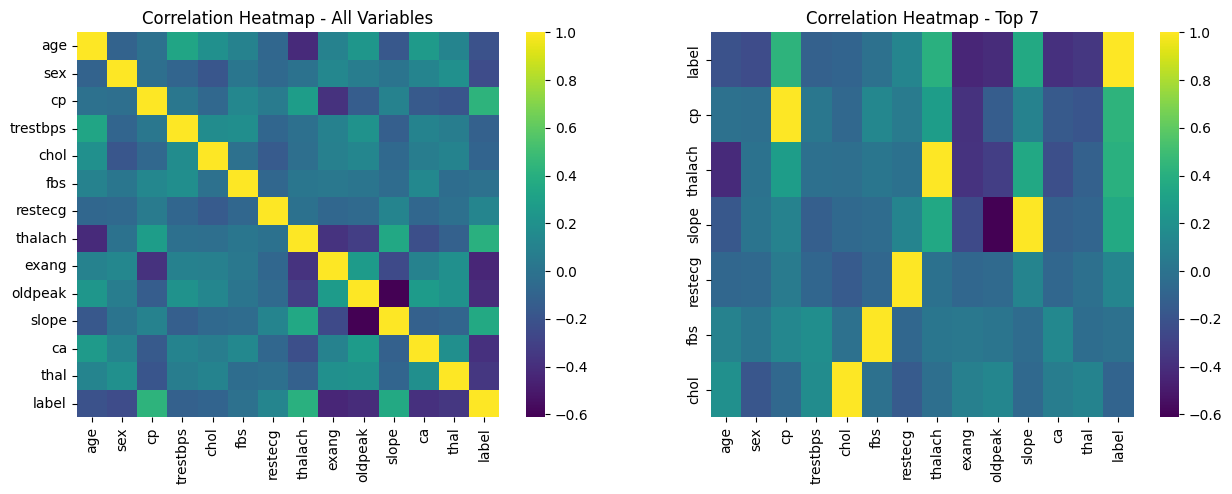

In [163]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title('Correlation Heatmap - All Variables')
sns.heatmap(train_dummy.corr(),cmap='viridis')
plt.subplot(122)
plt.title('Correlation Heatmap - Top 7')
sns.heatmap(train_dummy.corr().nlargest(7,'label'),cmap='viridis',annot=False)

# print(train_dummy.corr())
train_dummy.corr().nlargest(10,'label')

# Make a pairplot between all variables

<Figure size 2000x1000 with 0 Axes>

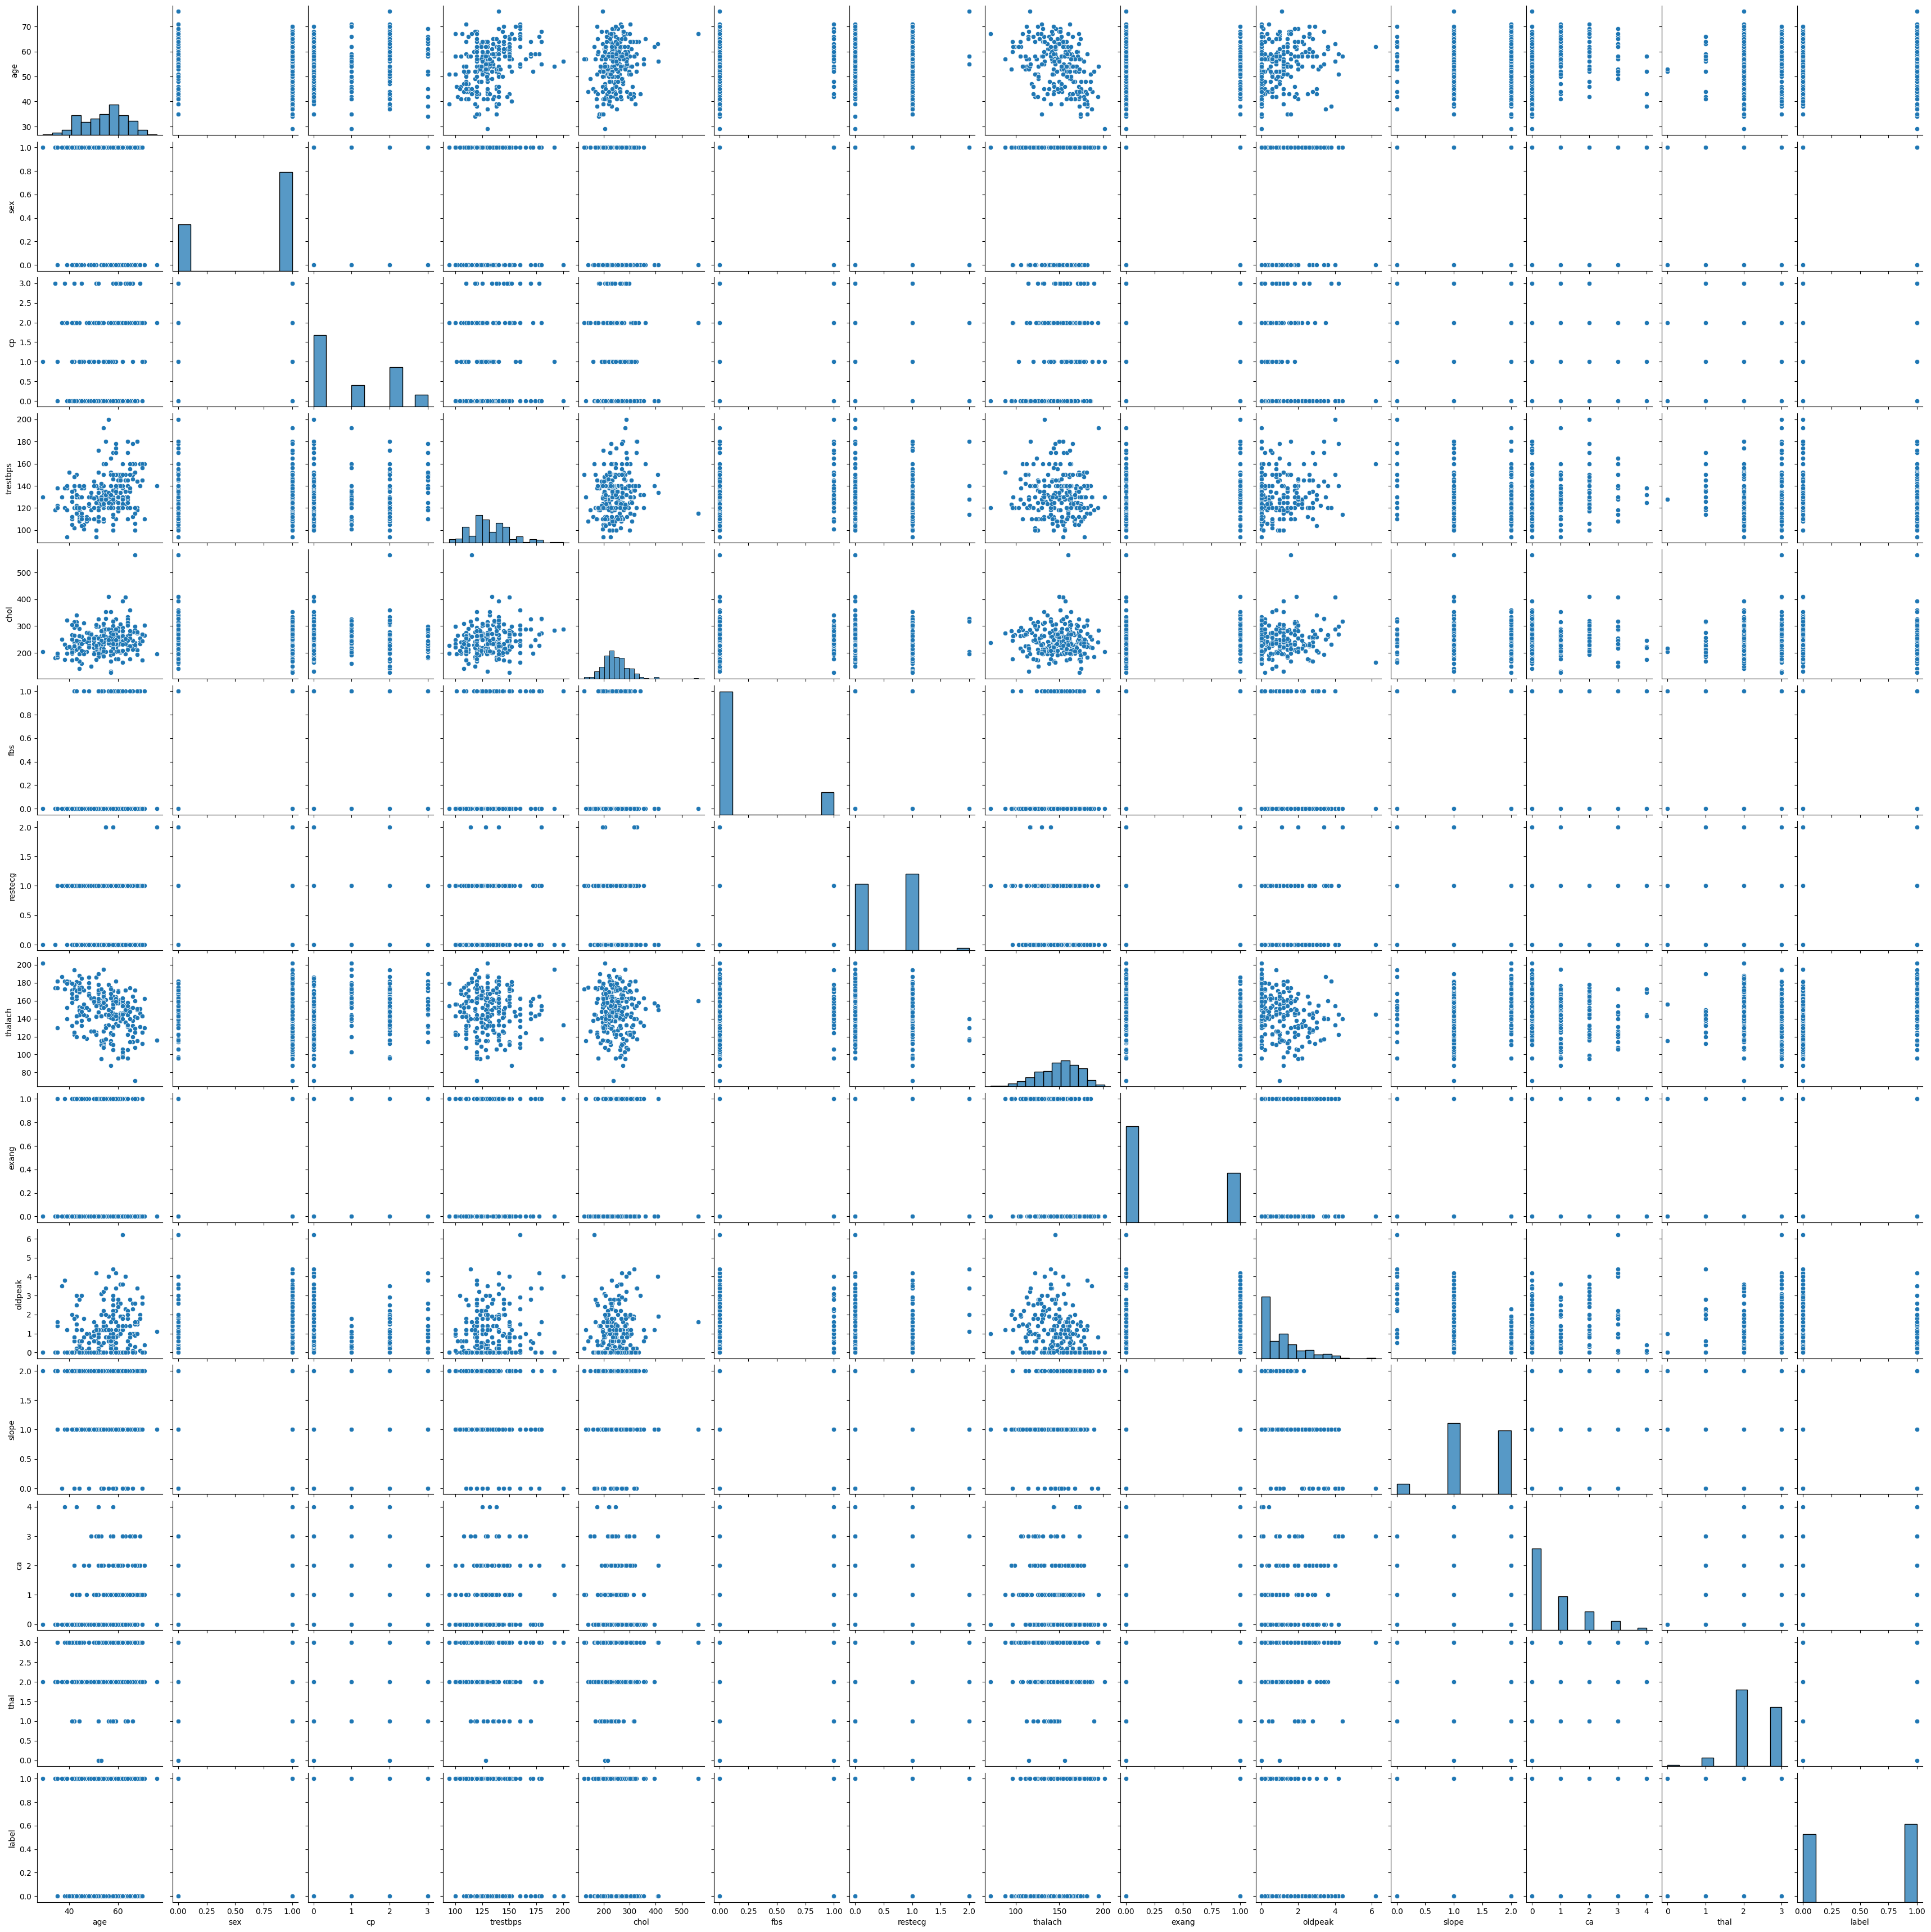

In [164]:
plt.figure(figsize=(20,10))
sns.pairplot(train_dummy)

Explore using statsmodels.api.OLS() for feature selection based on p-values

In [165]:
model = sm.OLS(train_dummy['label'],train_dummy)
res = model.fit()
sum = res.summary()

In [166]:
sum

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  label   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          5.288e+30
Date:                Sat, 15 Oct 2022   Prob (F-statistic):                        0.00
Time:                        09:54:18   Log-Likelihood:                          7922.2
No. Observations:                 241   AIC:                                 -1.582e+04
Df Residuals:                     227   BIC:                                 -1.577e+04
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age        -8.468e-17      1e-17     -8.453      0.000   -1.04e-16   -6.49e-17
sex        -2.368e-16   1.97e-16     -1.203      0.230   -6.25e-16    1.51e-16
cp          5.226e-17    9.6e-17      0.545      0.587   -1.37e-16    2.41e-16
trestbps     2.83e-17   4.96e-18      5.708      0.000    1.85e-17    3.81e-17
chol       -1.172e-17   1.77e-18     -6.624      0.000   -1.52e-17   -8.24e-18
fbs        -1.041e-17   2.47e-16     -0.042      0.966   -4.97e-16    4.76e-16
restecg    -1.553e-16   1.63e-16     -0.950      0.343   -4.77e-16    1.67e-16
thalach     2.282e-17   3.81e-18      5.994      0.000    1.53e-17    3.03e-17
exang       4.198e-16   2.12e-16      1.981      0.049    2.21e-18    8.37e-16
oldpeak     2.177e-16   1.02e-16      2.135      0.034    1.68e-17    4.19e-16
slope       3.695e-16   1.85e-16      1.993      0.047    4.16e-18    7.35e-16
ca         -1.561e-17   9.62e-17     -0.162      0.871   -2.05e-16    1.74e-16
thal       -5.204e-18   1.48e-16     -0.035      0.972   -2.96e-16    2.86e-16
label          1.0000    2.4e-16   4.17e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                        4.344   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.114   Jarque-Bera (JB):                5.169
Skew:                           0.115   Prob(JB):                       0.0754
Kurtosis:                       3.679   Cond. No.                         983.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3. Modeling

## Pipeline creation
<ul style="list-style:none">
    <li>
    1. Impute Missing Values // Scale/Encode Variables
    </li>
    <li>
    2. Apply Num/Cat Pipeline to Numerical/Categorical Variables
    </li>
    <li>
    3. Apply Classifier (Grid Search)
    </li>

In [167]:
## 1.
num_pipeline = Pipeline([('si',SimpleImputer(strategy='median')),('std',StandardScaler())])
cat_pipeline = Pipeline([('si',SimpleImputer(strategy='most_frequent')),('ohe',OneHotEncoder(handle_unknown='ignore'))])

In [168]:
## 2.
preprocessing_pipeline = ColumnTransformer([('num',num_pipeline,var_type['num']),('cat',cat_pipeline,var_type['cat'])])

See params from logistic regression

In [169]:
help(LogisticRegression)

Help on class LogisticRegression in module sklearn.linear_model._logistic:

class LogisticRegression(sklearn.linear_model._base.LinearClassifierMixin, sklearn.linear_model._base.SparseCoefMixin, sklearn.base.BaseEstimator)
 |  LogisticRegression(penalty='l2', *, dual=False, tol=0.0001, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None)
 |  
 |  Logistic Regression (aka logit, MaxEnt) classifier.
 |  
 |  In the multiclass case, the training algorithm uses the one-vs-rest (OvR)
 |  scheme if the 'multi_class' option is set to 'ovr', and uses the
 |  cross-entropy loss if the 'multi_class' option is set to 'multinomial'.
 |  (Currently the 'multinomial' option is supported only by the 'lbfgs',
 |  'sag', 'saga' and 'newton-cg' solvers.)
 |  
 |  This class implements regularized logistic regression using the
 |  'liblinear' library, 'newton-cg', 's

In [170]:
## 3.
lr_base = LogisticRegression()
l = len(train.columns)
params_lr = {'tol':[1e-4,1e-3,1e-2,1e-1,1,10],'C':[1e-2,1e-1,1,10]}
cvlr = RandomizedSearchCV(lr_base,param_distributions=params_lr)
pipeline_lr_base = Pipeline([('prep',preprocessing_pipeline),('lr_base',lr_base)])
pipeline_lr_opt = Pipeline([('prep',preprocessing_pipeline),('cvlr',cvlr)])

print('Logistic Regression Tuned')
pipeline_lr_opt.fit(train,trainLab)
print(classification_report(testLab,pipeline_lr_opt.predict(test)))

Logistic Regression Tuned


c:\Users\admin\Work\Simplilearn\Machine Learning\project2\env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.95      0.77      0.85        26
           1       0.85      0.97      0.91        35

    accuracy                           0.89        61
   macro avg       0.90      0.87      0.88        61
weighted avg       0.89      0.89      0.88        61



See Params from RandomForestClassifier

In [171]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [172]:
## 3.
rf_base = RandomForestClassifier()
params_rf = {'n_estimators':[100,500,1000,5000],'criterion':['gini','entropy'],'max_depth':[l//3,l//2,(2*l)//3]}
cvrf = RandomizedSearchCV(rf_base,param_distributions=params_rf,n_iter=5)

pipeline_rf_base = Pipeline([('prep',preprocessing_pipeline),('rf_base',rf_base)])
pipeline_rf_opt = Pipeline([('prep',preprocessing_pipeline),('cvrf',cvrf)])

print('Random Forest Tuned Model')
pipeline_rf_opt.fit(train,trainLab)
print(classification_report(testLab,pipeline_rf_opt.predict(test)))


Random Forest Tuned Model
              precision    recall  f1-score   support

           0       0.86      0.73      0.79        26
           1       0.82      0.91      0.86        35

    accuracy                           0.84        61
   macro avg       0.84      0.82      0.83        61
weighted avg       0.84      0.84      0.83        61



In [173]:
vc = VotingClassifier(estimators=[('cvrf',cvrf),('cvlr',cvlr)],)
params_vc = {'weights':[[0.1,0.9],[0.2,0.8],[0.4,0.6],[0.9,0.1],[0.8,0.2],[0.6,0.4]]}
vc_opt = RandomizedSearchCV(vc,param_distributions=params_vc,n_iter=5)

print('Voting Classifier Tuned Model')
pipeline_vc = Pipeline([('pred',preprocessing_pipeline),('vc',vc_opt)])
pipeline_vc.fit(train,trainLab)
print(classification_report(testLab,pipeline_vc.predict(test)))



Voting Classifier Tuned Model


c:\Users\admin\Work\Simplilearn\Machine Learning\project2\env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\admin\Work\Simplilearn\Machine Learning\project2\env\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [ ]:
# def mean_enc(col):
#     mean_enc = {}
#     df = train.copy()
#     df['label'] = trainLab
#     x = df.groupby(by=col).mean()['label']
#     return {ind:x[ind] for ind in x.index}

# for col in var_type['cat']:
#     me = mean_enc(col)
#     train[f'{col}_me'] = train[col].map(me)
#     test[f'{col}_me'] = test[col].map(me)